In [1]:
# Import Libraries
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Function to extract MFCCs with time dimension
def extract_mfcc_series(file_path, n_mfcc=13, max_len=200):
    audio, sample_rate = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    
    # Pad or truncate MFCCs to a fixed length
    if mfcc.shape[1] < max_len:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_len - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc

# Directory containing audio files
audio_speech = 'AudioWav'

# Extract features and labels
features = []
labels = []

# Loop over each file in the directory
# Extract features for each file
for file_name in os.listdir(audio_speech):
    if file_name.endswith('.wav'):
        file_path = os.path.join(audio_speech, file_name)
        label = file_name.split('_')[2]  # extract the emotion label
        mfcc_series = extract_mfcc_series(file_path)
        features.append(mfcc_series)
        labels.append(label)

# Convert to DataFrame
features_df = pd.DataFrame({'Features': features, 'Label': labels})

# Expand feature columns for model compatibility
print(features_df)

# Inspect unique labels extracted from file names
unique_labels = sorted(set(labels))
print("Unique Labels Extracted from File Names:", unique_labels)

                                               Features Label
0     [[-589.87604, -507.21228, -465.8268, -460.9645...   ANG
1     [[-494.1741, -463.85815, -459.60843, -453.1035...   DIS
2     [[-466.0973, -458.1281, -459.86917, -459.22717...   FEA
3     [[-465.77594, -436.83945, -431.25726, -436.799...   HAP
4     [[-484.9637, -454.3514, -450.37292, -445.42505...   NEU
...                                                 ...   ...
7437  [[-541.3534, -512.39343, -513.9822, -510.95755...   DIS
7438  [[-500.56378, -506.89853, -517.6963, -514.3520...   FEA
7439  [[-546.4652, -513.5806, -509.9367, -507.84128,...   HAP
7440  [[-549.4096, -518.13605, -514.4069, -513.1063,...   NEU
7441  [[-555.97235, -515.94165, -507.71866, -508.487...   SAD

[7442 rows x 2 columns]
Unique Labels Extracted from File Names: ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']


In [3]:
# Encode labels
le = LabelEncoder()
labels = le.fit_transform(labels)

# Verify the mapping between numeric and descriptive labels
label_mapping = {index: label for index, label in enumerate(le.classes_)}
print("Label Mapping (Numeric to Descriptive):", label_mapping)

# Convert features and labels intp numpy arrays
X = np.array(features)
y = np.array(labels)

# Split the data: 60% training, 20% validation, 20% testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=True)

# Print the split sizes for verification
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Label Mapping (Numeric to Descriptive): {0: 'ANG', 1: 'DIS', 2: 'FEA', 3: 'HAP', 4: 'NEU', 5: 'SAD'}
Training set size: 4465
Validation set size: 1488
Test set size: 1489


In [23]:
# Define the CNN + LSTM model
class CNN_LSTM(nn.Module):
    def __init__(self, n_mfcc, max_len, num_classes):
        super(CNN_LSTM, self).__init__()
        
        # CNN layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=(1, 1))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1))
        self.pool = nn.MaxPool2d((2, 2))
        self.dropout = nn.Dropout(0.3)
        
        # Calculate the output dimensions after CNN layers
        cnn_out_height = n_mfcc // 4  # Pooling reduces height by a factor of 2 twice
        cnn_out_width = max_len // 4  # Pooling reduces width by a factor of 2 twice
        lstm_input_size = 64 * cnn_out_height  # 64 channels * reduced height
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size=lstm_input_size, hidden_size=128, num_layers=2, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # CNN layers
        x = x.unsqueeze(1)  # Add channel dimension for CNN (batch, 1, n_mfcc, max_len)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        
        # Reshape for LSTM
        batch_size, _, height, width = x.size()
        x = x.view(batch_size, width, -1)  # (batch, sequence_length=width, features=channels*height)
        
        # LSTM layers
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Take the output from the last time step
        
        # Fully connected layer
        x = self.fc(x)
        return x



In [24]:
# Model parameters
n_mfcc = 13
max_len = 200
num_classes = len(le.classes_)
model = CNN_LSTM(n_mfcc=n_mfcc, max_len=max_len, num_classes=num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with validation
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Evaluate on validation set
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    # Validation Accuracy
    val_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, "
          f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")


# Test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
# Test model accuracy
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Epoch [1/20], Loss: 1.5074, Validation Loss: 1.4054, Validation Accuracy: 45.23%
Epoch [2/20], Loss: 1.3685, Validation Loss: 1.3815, Validation Accuracy: 46.24%
Epoch [3/20], Loss: 1.3244, Validation Loss: 1.3621, Validation Accuracy: 46.44%
Epoch [4/20], Loss: 1.2727, Validation Loss: 1.3590, Validation Accuracy: 46.77%
Epoch [5/20], Loss: 1.2499, Validation Loss: 1.3409, Validation Accuracy: 45.63%
Epoch [6/20], Loss: 1.1902, Validation Loss: 1.4548, Validation Accuracy: 42.14%
Epoch [7/20], Loss: 1.1201, Validation Loss: 1.4155, Validation Accuracy: 45.77%
Epoch [8/20], Loss: 1.0735, Validation Loss: 1.4904, Validation Accuracy: 43.62%
Epoch [9/20], Loss: 1.0258, Validation Loss: 1.4907, Validation Accuracy: 42.20%
Epoch [10/20], Loss: 0.9397, Validation Loss: 1.5852, Validation Accuracy: 43.75%
Epoch [11/20], Loss: 0.8382, Validation Loss: 1.6615, Validation Accuracy: 41.87%
Epoch [12/20], Loss: 0.7774, Validation Loss: 1.6388, Validation Accuracy: 43.75%
Epoch [13/20], Loss: 0.68

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Placeholder lists to store true and predicted labels
y_true = []
y_pred = []

# Switch model to evaluation mode
model.eval()
with torch.no_grad():
    # Use the test data loader to evaluate the model on the hold-out test set
    for X_batch, y_batch in test_loader:  
        outputs = model(X_batch)  # Get model predictions
        _, predicted = torch.max(outputs, 1)  # Extract the predicted class for each sample
        
        # Append true and predicted labels
        y_true.extend(y_batch.cpu().numpy())  # Convert true labels to numpy and add to list
        y_pred.extend(predicted.cpu().numpy())  # Convert predicted labels to numpy and add to list

# Convert lists to numpy arrays for evaluation
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Ensure that le.classes_ is a list of strings
print("le.classes_: ", le.classes_)
print("Type of le.classes_: ", type(le.classes_))
# Generate descriptive class names for classification report
class_names = [label_mapping[i] for i in range(len(label_mapping))]
print("Class Names for Evaluation:", class_names)


# Generate a classification report
report = classification_report(y_true, y_pred, target_names=class_names)  # Use the list of class names
print("Classification Report:")
print(report)

le.classes_:  ['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']
Type of le.classes_:  <class 'numpy.ndarray'>
Class Names for Evaluation: ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']
Classification Report:
              precision    recall  f1-score   support

         ANG       0.56      0.49      0.52       255
         DIS       0.39      0.31      0.34       254
         FEA       0.34      0.25      0.29       254
         HAP       0.38      0.42      0.40       255
         NEU       0.42      0.50      0.46       217
         SAD       0.43      0.56      0.48       254

    accuracy                           0.42      1489
   macro avg       0.42      0.42      0.42      1489
weighted avg       0.42      0.42      0.41      1489



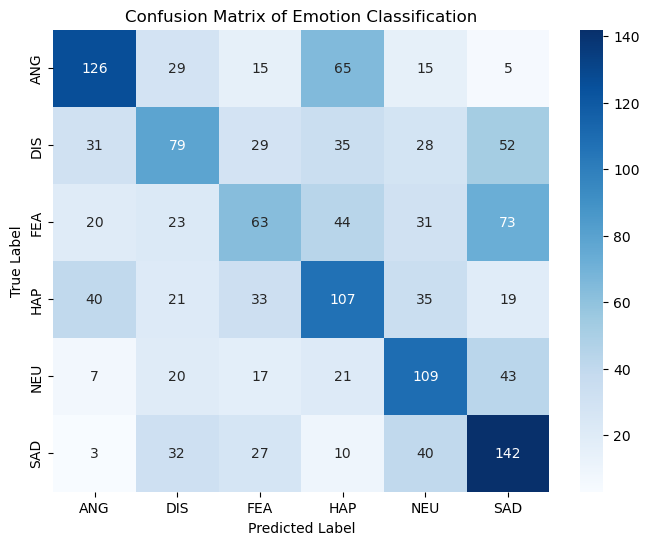

In [26]:
# Generate a confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)  # Use string class names for labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of Emotion Classification")
plt.show()